# Demonstration of dpipe

In [1]:
import sys
sys.path.insert(0, '/Users/robertyi/repos/dataframe/dpipe')
from dpipe import *
from dpipe.sampledata.datagen import user_data, purchase_data
import dpipe as dp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Create some synthetic data
Let's start by making some synthetic data. Below I use some boilerplate numpy + pandas code to generate some weekly fluctuating revenue data.

In [2]:
users = user_data(1000, random_state=2701)
purchases = purchase_data(1000)

## Overview of data
We have two tables:

* `users`
* `purchases`

These should roughly mirror the kind of information companies will typically log (if star schema is being used) -- dimension tables describing *states*, such as a user information table; fact tables describing *events*, such as a purchases or visits table.

We'll assume we've loaded these as `pd.DataFrame`s from your data lake. Let's see how we would traditionally parse these.

## Plotting

Even for basic plotting of time trends, this can be quite cumbersome. Tools like superset and tableau make this significantly easier, but for data scientists who like to stay within the python ecosystem, substantial cleaning will nonetheless be required.

### Histograms

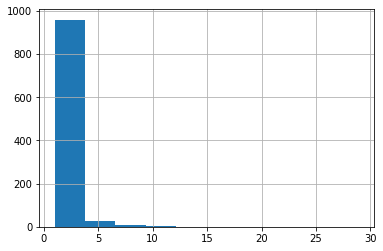

In [3]:
purchases.sale_value.hist()

Histograms are quite easy to plot, but typically some sort of log-scaling is necessary, especially for long-tailed distributions.

Iterations are usually required.

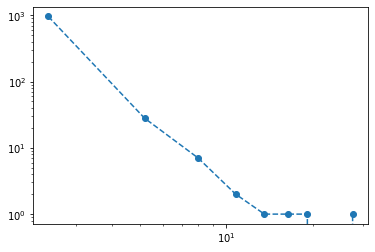

In [4]:
y, x = np.histogram(purchases.sale_value)
plt.plot((x[1:] + x[:-1])/2, y, 'o--')
plt.xscale('log')
plt.yscale('log')

`dpipe` makes this just as easy, but with a few small QOL improvements:

* Declarative syntax.
* Automatic ipython-suitable styling.
* Better defaults.

Moreover, the functions wrap matplotlib/pandas/numpy, so any arguments that apply to the base functions can be passed.

In [24]:
# We support dark mode (not on by default).
# Enabling it here because we like it.
import dpipe
dpipe.style.rc['style'] = 'dark_mode'

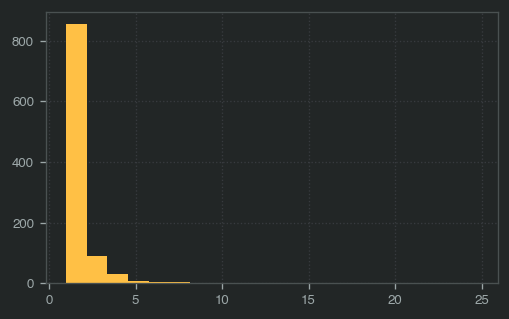

In [25]:
a = purchases.sale_value >> Hist(bins=20);

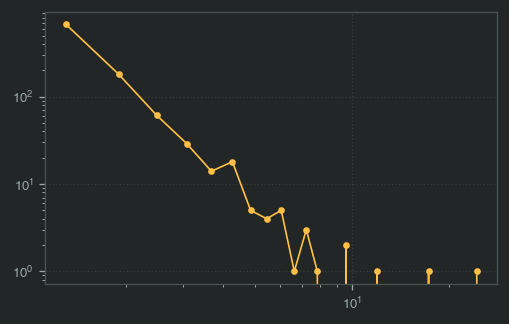

In [26]:
purchases.sale_value >> LogLogHist(bins=40)

## Scatter plots

In [27]:
a, b, c = np.array_split(users, 3)

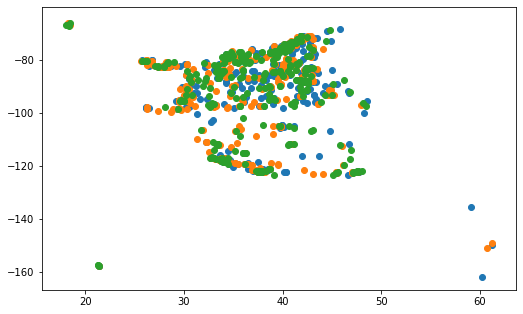

In [28]:
plt.figure(figsize=(8.5,5.2))
plt.scatter(a.lat, a.lng)
plt.scatter(b.lat, b.lng)
plt.scatter(c.lat, c.lng)

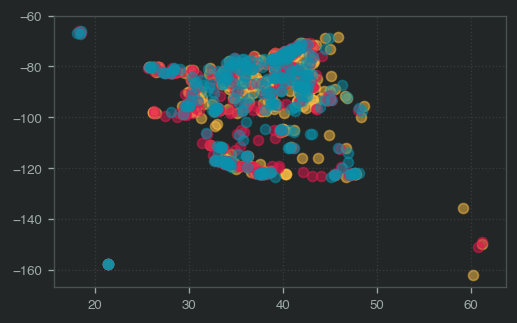

In [29]:
(a.lat, a.lng) >> Scatter
(b.lat, b.lng) >> Scatter()
(c.lat, c.lng) >> Scatter()

## Aggregations

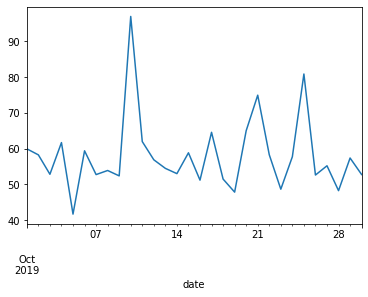

In [30]:
purchases_copy = purchases.copy()
purchases_copy['date'] = pd.to_datetime(purchases_copy.date)
gb = purchases_copy.groupby('date').sum()['sale_value']
gb.plot()

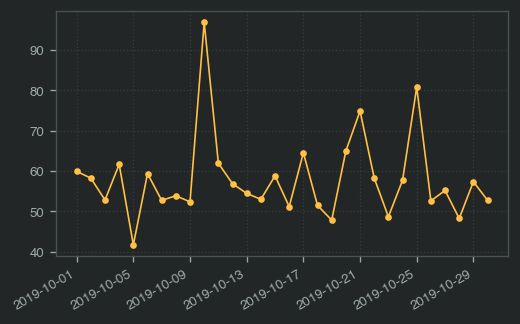

In [31]:
purchases >> ToDatetime('date') >> GroupBy('date') >> Sum('sale_value') >> Plot

## Light mode

In [32]:
import dpipe
dpipe.style.rc['style'] = 'light_mode'

In [33]:
purchases.\
    copy().\
    sample(100)

,id_user,date,sale_value
219,827.0,2019-10-20,2.003980
539,991.0,2019-10-06,1.435406
554,594.0,2019-10-27,1.298794
580,269.0,2019-10-20,1.616468
399,523.0,2019-10-30,1.154869
...,...,...,...
744,118.0,2019-10-19,1.196568
848,786.0,2019-10-27,1.189918
551,481.0,2019-10-30,1.057630
538,424.0,2019-10-22,1.363304


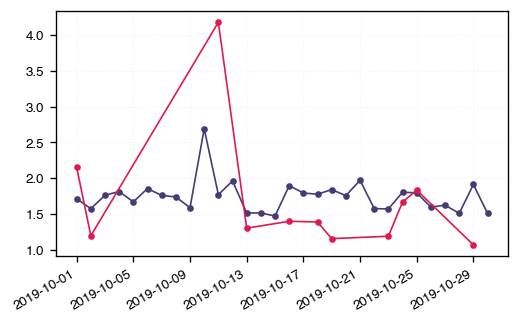

In [34]:
purchases >> ToDatetime('date') >> GroupBy('date') >> Mean('sale_value') >> Plot
new_purchases = purchases.sample(20, replace=True)
new_purchases >> GroupBy('date') >> Mean('sale_value') >> Plot

## ML

In [2]:
modelspec = (users, purchases) \
    >> Merge(on='id_user') \
    >> Select('population', 'density', 'sale_value', 'city') \
    >> InitModel(label='sale_value') \
    >> LabelEnc(columns=['city']) \
    >> TrainTestSplit(random_state=2701) \
    >> LinearReg

Training set
------------ 
Max error: 1.4412804399767905
Mean absolute error: 0.30748155095670965
Mean squared error: 0.20055856528464752
Root mean squared error: 0.4478376550544265


Test set
-------- 
Max error: 1.0820421961311388
Mean absolute error: 0.4085741019262599
Mean squared error: 0.31357196319895575
Root mean squared error: 0.5599749665823962


## Classifier

In [13]:
df = (users, purchases) \
    >> Merge(on='id_user')

# Create a mock "sales" column.
df['sales'] = (df['sale_value'] > 1.2).astype(int)

In [18]:
modelspec = df \
    >> Select('population', 'density', 'sales') \
    >> InitModel(label='sales') \
    >> TrainTestSplit(random_state=2701) \
    >> LogisticReg